In [54]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [51]:
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [ ]:
PATH_TO_CSV = Path("../data_clean/processed_data_with_features.csv")
df = pd.read_csv(PATH_TO_CSV)

df["DATETIME"] = pd.to_datetime(df["DATETIME"])

df = df.sort_values(["SYMBOL", "DATETIME"]).reset_index(drop=True)

print("Rows:", len(df))
df.head()

Rows: 398808


,DATE,SYMBOL,TIME,MID_OPEN,DATE_FORMATTED,DATETIME,DAY_OF_THE_WEEK,HOUR_OF_DAY,LOG_RETURN,vol_5,...,log_momentum_60,ewm_60,bb_upper_60,bb_lower_60,mdd_60,ema_12,ema_26,macd,macd_signal,macd_hist
0,20211201,A,09:30:00,152.190,2021-12-01,2021-12-01 09:30:00,Wednesday,9,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,152.190000,152.190000,0.000000,0.000000,0.000000
1,20211201,A,09:40:00,150.490,2021-12-01,2021-12-01 09:40:00,Wednesday,9,-0.011233,NaN,...,NaN,-0.011233,NaN,NaN,NaN,151.928462,152.064074,-0.135613,-0.027123,-0.108490
2,20211201,A,09:50:00,151.475,2021-12-01,2021-12-01 09:50:00,Wednesday,9,0.006524,NaN,...,NaN,-0.010651,NaN,NaN,NaN,151.858698,152.020439,-0.161741,-0.054046,-0.107695
3,20211201,A,10:00:00,150.510,2021-12-01,2021-12-01 10:00:00,Wednesday,10,-0.006391,NaN,...,NaN,-0.010511,NaN,NaN,NaN,151.651206,151.908555,-0.257348,-0.094707,-0.162642
4,20211201,A,10:10:00,151.960,2021-12-01,2021-12-01 10:10:00,Wednesday,10,0.009588,NaN,...,NaN,-0.009852,NaN,NaN,NaN,151.698713,151.912365,-0.213652,-0.118496,-0.095157


In [55]:
FEATURES = [
    "DAY_OF_THE_WEEK","HOUR_OF_DAY",
    "LOG_RETURN",
    "vol_20","vol_60",
    "sr_20",
    "mean_20",
    "zscore_20","zscore_60",
    "log_momentum_20","log_momentum_60",
    "bb_upper_20","bb_lower_20",
    "mdd_20",
    "ema_12","ema_26",
    "macd","macd_signal","macd_hist"
]

In [56]:
df = df.dropna(subset=FEATURES + ["LOG_RETURN"]).reset_index(drop=True)
df["DAY_OF_THE_WEEK"] = df["DATETIME"].dt.dayofweek

In [57]:
WINDOW = 20

X_seqs = []
y_seqs = []
symbol_list = []

for symbol, group in df.groupby("SYMBOL"):
    group = group.sort_values("DATETIME").reset_index(drop=True)
    for i in range(len(group) - WINDOW):
        X_seqs.append(group.loc[i:i+WINDOW-1, FEATURES].values)
        y_seqs.append(group.loc[i+WINDOW, "LOG_RETURN"])
        symbol_list.append(symbol)

X = np.stack(X_seqs)
y = np.array(y_seqs)
symbols = np.array(symbol_list)

In [58]:
X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
y = np.nan_to_num(y, nan=0.0, posinf=0.0, neginf=0.0)

means = X.mean(axis=(0,1), keepdims=True)
stds  = X.std(axis=(0,1), keepdims=True) + 1e-8
X = (X - means) / stds

y_mean, y_std = y.mean(), y.std() + 1e-8
y = (y - y_mean) / y_std

print("Dataset shape:", X.shape, y.shape)

Dataset shape: (360488, 20, 19) (360488,)


In [59]:
N = len(X)
cut = int(N * 0.8)

X_train, X_test = X[:cut], X[cut:]
y_train, y_test = y[:cut], y[cut:]
symbols_train, symbols_test = symbols[:cut], symbols[cut:] 

print("Train:", X_train.shape, "| Test:", X_test.shape)

Train: (288390, 20, 19) | Test: (72098, 20, 19)


In [68]:
class SequenceDataset(Dataset):
    def __init__(self, X, y, symbols):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
        self.symbols = np.array(symbols) 

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], self.symbols[idx]

BATCH_SIZE = 256

train_ds = SequenceDataset(X_train, y_train, symbols_train)
test_ds  = SequenceDataset(X_test,  y_test,  symbols_test)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_dl  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

In [69]:
class ReturnLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=64):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.head = nn.Sequential(
            nn.LayerNorm(hidden_size),
            nn.Linear(hidden_size, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        return self.head(h_n[-1])

model = ReturnLSTM(input_size=X.shape[2]).to(device)

loss_fn  = nn.SmoothL1Loss(beta=1e-2)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

In [70]:
EPOCHS = 10
for epoch in range(1, EPOCHS + 1):
    model.train()
    tot = 0.0
    for xb, yb, _ in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        loss = loss_fn(model(xb), yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        tot += loss.item() * len(xb)
    print(f"Epoch {epoch:02d} | Train Huber: {tot/len(train_ds):.6f}")


Epoch 01 | Train Huber: 0.587552
Epoch 02 | Train Huber: 0.584485
Epoch 03 | Train Huber: 0.582340
Epoch 04 | Train Huber: 0.580445
Epoch 05 | Train Huber: 0.578294
Epoch 06 | Train Huber: 0.576128
Epoch 07 | Train Huber: 0.574047
Epoch 08 | Train Huber: 0.572266
Epoch 09 | Train Huber: 0.570441
Epoch 10 | Train Huber: 0.568633


In [71]:
torch.save(model.state_dict(), "model_2.pth")

In [72]:
model.eval()
preds, truths, symbols_out = [], [], []

with torch.no_grad():
    for xb, yb, sb in test_dl:
        xb = xb.to(device)
        pred = model(xb).cpu().numpy().ravel()
        preds.append(pred)
        truths.append(yb.numpy().ravel())
        symbols_out.extend(sb)

y_pred = np.concatenate(preds)
y_true = np.concatenate(truths)
symbols_out = np.array(symbols_out)

In [78]:
y_pred_raw = y_pred * y_std + y_mean
y_true_raw = y_true * y_std + y_mean

mse_scaled = np.mean((y_pred - y_true) ** 2)
mse_raw    = np.mean((y_pred_raw - y_true_raw) ** 2)

corr = np.corrcoef(y_pred, y_true)[0, 1]
accuracy = np.mean((y_pred > 0) == (y_true > 0))

print(f"Test MSE (scaled): {mse_scaled:.6e}")
print(f"Test MSE (raw)   : {mse_raw:.6e}")
print(f"Pearson r        : {corr:.4f}")
print(f"Directional Accuracy: {accuracy:.2%}")

Test MSE (scaled): 8.157048e-01
Test MSE (raw)   : 7.809831e-06
Pearson r        : 0.3021
Directional Accuracy: 57.29%


In [74]:
# Per-stock metrics
from sklearn.metrics import mean_squared_error

mse_by_stock = {}
corr_by_stock = {}
acc_by_stock = {}

for symbol in np.unique(symbols_out):
    idx = (symbols_out == symbol)
    y_t = y_true[idx]
    y_p = y_pred[idx]

    if len(y_t) < 5:
        continue

    mse_by_stock[symbol] = mean_squared_error(y_t, y_p)
    corr_by_stock[symbol] = np.corrcoef(y_t, y_p)[0, 1] if np.std(y_t) > 0 else np.nan
    acc_by_stock[symbol] = np.mean((y_p > 0) == (y_t > 0))

In [75]:
results_df = pd.DataFrame({
    "MSE": mse_by_stock,
    "Corr": corr_by_stock,
    "Accuracy": acc_by_stock,
}).sort_values("Corr", ascending=False)

print("\nTop 10 stocks by correlation:")
display(results_df.head(10))

print("\nBottom 10 stocks by correlation:")
display(results_df.tail(10))


Top 10 stocks by correlation:


,MSE,Corr,Accuracy
TFC,0.613693,0.530190,0.629630
SYF,1.049312,0.496576,0.587302
USB,0.536536,0.492263,0.615079
TXT,0.622911,0.480696,0.605820
STT,0.816460,0.473721,0.629630
VLO,1.200885,0.469758,0.593915
SLB,1.112937,0.463683,0.579365
SCHW,0.745910,0.462234,0.592593
TRGP,1.001327,0.445961,0.599206
WAB,0.502165,0.440879,0.585979



Bottom 10 stocks by correlation:


,MSE,Corr,Accuracy
SMCI,1.989985,0.162448,0.530423
STZ,0.301503,0.162148,0.542328
XEL,0.453285,0.159530,0.530423
SWKS,2.196620,0.158466,0.574074
VRSK,0.609837,0.155545,0.579365
SJM,0.382192,0.147210,0.572751
VZ,0.251270,0.111575,0.544974
VRTX,0.479275,0.055284,0.523810
WMT,0.374062,-0.080230,0.560847
TPL,12.690496,-0.316266,0.409091


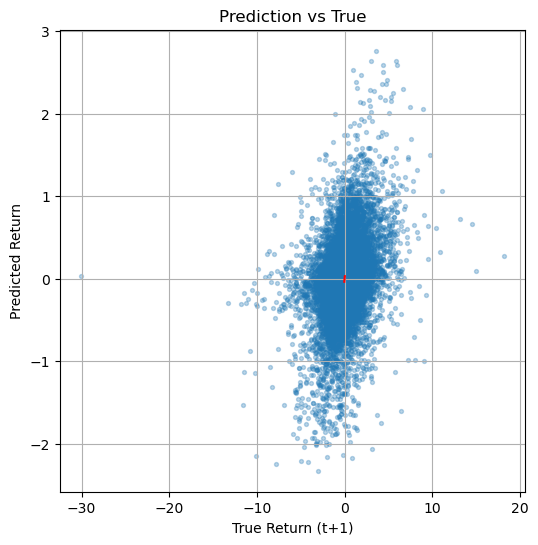

In [76]:
plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, alpha=0.3, s=8)
plt.xlabel("True Return (t+1)")
plt.ylabel("Predicted Return")
plt.title("Prediction vs True")
plt.grid(True)
plt.plot([-0.05, 0.05], [-0.05, 0.05], 'r--')
plt.show()